In [139]:
import re
import json
from tqdm.auto import tqdm
import wandb
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter


sb.set_theme(style="white", palette=None)

In [143]:
# connect to wandb and get list of runs
api_helper = wandb.Api(api_key='3138e1b24deb278ed045d0dedb39511d3a96245b')
runs = list(api_helper.runs(path='yuting_fyp/In-context-learning for Dialogue Summarization',
                     per_page=1000))
runs

[<Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/vg8hsptk (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/xxhu3nxo (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/e17vj9et (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/umgst3jy (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/r575zw56 (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/qms1n1nx (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/l25edc50 (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/zyw5rqyt (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/pqkjl5vj (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/512pfk7x (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/1cq9vju4 (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summari

In [144]:
# iterate over runs to get metric tables
run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags:
        continue
    else:
        print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Evaluation metrics Table' in getattr(file, 'name', '')]
    assert len(metric_file) == 1
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metric_table = pd.read_json(json.dumps(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
    except AttributeError as e:
        if run.name == 'Cerebras-GPT-13B-1shot':
            match = re.search(r'\dshot', run.name)
            start_i, end_i = match.span()
            k = int(run.name[start_i: end_i][0])
        else:
            raise e
    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    if run.name == 'Cerebras-6.7B-3-shot':
        metric_table['model_name'] = 'Cerebras-GPT-6.7B'
    else:
        metric_table['model_name'] = model_name

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/70 [00:00<?, ?it/s]

parsing run llama-7b-hf-2-shot
parsing run llama-7b-hf-3-shot
parsing run llama-7b-hf-1-shot
parsing run mt5-xl-3-shot-2-keyword
parsing run mt5-xl-3-shot-1-keyword
parsing run mt5-xl-2-shot-2-keyword
parsing run mt5-xl-2-shot-1-keyword
parsing run mt5-xl-1-shot-3-keyword
parsing run mt5-xl-1-shot-2-keyword
parsing run mt5-xl-1-shot-1-keyword
parsing run bloom-3b-5-shot
parsing run Cerebras-GPT-6.7B-2-shot
parsing run Cerebras-GPT-6.7B-1-shot
parsing run llama-7b-hf-1-shot
parsing run opt-iml-1.3b-3-shot
parsing run opt-iml-1.3b-1-shot
parsing run opt-iml-1.3b-2-shot
parsing run bloom-3b-3-shot
parsing run bloom-3b-2-shot
parsing run bloom-3b-1-shot
parsing run bloom-7b1-3-shot
parsing run bloom-7b1-5-shot
parsing run bloom-7b1-1-shot
parsing run bloom-7b1-2-shot
parsing run Cerebras-GPT-13B-3-shot
parsing run Cerebras-GPT-13B-2-shot
parsing run Cerebras-GPT-13B-1shot
parsing run Cerebras-GPT-2.7B-3-shot
parsing run Cerebras-GPT-2.7B-2-shot
parsing run Cerebras-GPT-2.7B-1-shot
parsing 

{'llama-7b-hf-2-shot':    run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
 0       0           0.437671        0.265685          0.310381   
 1       1           0.423863        0.263383          0.303390   
 2       2           0.436480        0.258411          0.304840   
 3       3           0.423201        0.261422          0.302913   
 4       4           0.434595        0.259540          0.304687   
 
    rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  rouge_L_precision  \
 0           0.106896        0.061260          0.072295           0.324801   
 1           0.101557        0.060294          0.070178           0.318110   
 2           0.105790        0.059166          0.070802           0.323473   
 3           0.101061        0.061060          0.070881           0.314505   
 4           0.104727        0.059114          0.070628           0.326289   
 
    rouge_L_recall  rouge_L_fmeasure  k   model_name  
 0        0.191619          0.225881  2  llama-7b

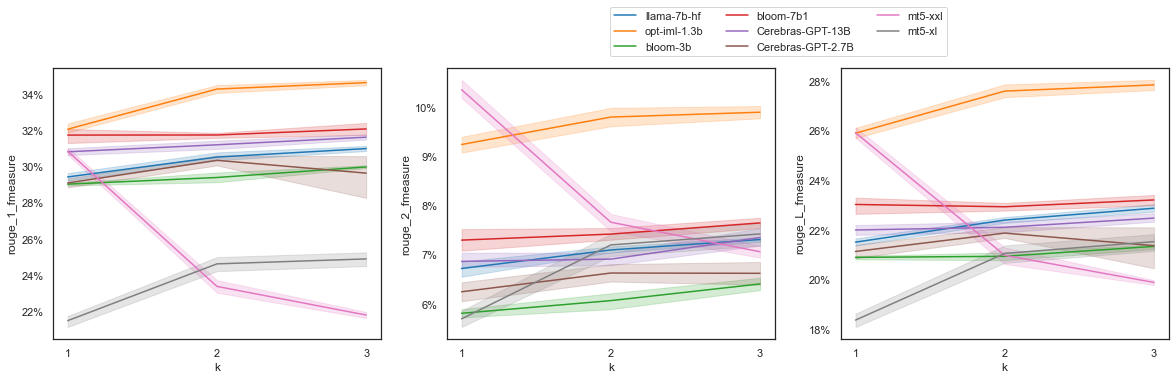

In [145]:
# parse the result of direct prompt
new_keys = [x for x in run2metric_table.keys() if 'keyword' not in x]
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table = rouge_table[(rouge_table['k'] <= 3) & ~rouge_table.isna().any(axis=1)]
rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='model_name', ax=axes[0], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='model_name', ax=axes[1], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='model_name', ax=axes[2], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=3, bbox_to_anchor=(.75, 0.98))

plt.savefig('direct_prompt.jpg', dpi=500, bbox_inches='tight')

In [142]:
rouge_table[rouge_table['model_name'].str.contains('llama')]

,run_id,rouge_1_precision,rouge_1_recall,rouge_1_fmeasure,rouge_2_precision,rouge_2_recall,rouge_2_fmeasure,rouge_L_precision,rouge_L_recall,rouge_L_fmeasure,k,model_name
15,0,0.431931,0.252426,0.297348,0.102890,0.057693,0.068770,0.322528,0.183735,0.217739,1,llama-7b-hf
16,1,0.437103,0.250974,0.296973,0.105282,0.057676,0.068879,0.322644,0.181442,0.215789,1,llama-7b-hf
17,2,0.423837,0.248366,0.292270,0.101924,0.055305,0.066367,0.317199,0.181877,0.215124,1,llama-7b-hf
18,3,0.422479,0.249433,0.291386,0.102662,0.057682,0.067817,0.315080,0.181688,0.213436,1,llama-7b-hf
19,4,0.427976,0.249376,0.293450,0.098162,0.053510,0.064106,0.316756,0.180380,0.213234,1,llama-7b-hf


5      True
6      True
7      True
8      True
9      True
       ... 
140    True
141    True
142    True
143    True
144    True
Length: 125, dtype: bool